In [3]:
#Exercise 1
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

data = pd.read_csv('league_of_legends_data_large.csv')

X = data.drop('win', axis=1)  # features
y = data['win']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # fit_transform: scaled data based on the learned params
X_test_scaled = scaler.transform(X_test) # transform: apply same transformation

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [6]:
# Exercise 2
import torch.nn as nn
import torch.optim as optim

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # SGD Optimizer
# model.parameters() => obj containing params


In [ ]:
# Exercise 3
epochs = 10000

for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()

    outputs = model(X_train_tensor)

    loss = criterion(outputs, y_train_tensor)

    loss.backward()

    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor)
    test_preds = model(X_test_tensor)

    train_preds = (train_preds >= 0.5).float()
    test_preds = (test_preds >= 0.5).float()

    train_accuracy = (train_preds == y_train_tensor).float().mean()
    test_accuracy = (test_preds == y_test_tensor).float().mean()

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")


In [ ]:
# Exercise 4
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
# Training Loop
for epoch in range(epochs):
    model.train() # Set model to training (or evaluation in later) mode
    optimizer.zero_grad() # clear previous
    outputs = model(X_train_tensor) #forward pass
    loss = criterion(outputs, y_train_tensor) # loss calculation
    loss.backward() # compute backprop of the loss
    optimizer.step() # update params using computed gradients from loss

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

model.eval() # set to evaluation mode
with torch.no_grad(): # disable gradient computation
    train_preds = model(X_train_tensor)
    test_preds = model(X_test_tensor)
    train_preds = (train_preds >= 0.5).float() # convert prediction to label
    test_preds = (test_preds >= 0.5).float()

    train_accuracy = (train_preds == y_train_tensor).float().mean()
    test_accuracy = (test_preds == y_test_tensor).float().mean()

    print(f"Training Accuracy with L2 Regularization: {train_accuracy:.4f}")
    print(f"Testing Accuracy with L2 Regularization: {test_accuracy:.4f}")


Epoch [100/1000], Loss: 0.6856
Epoch [200/1000], Loss: 0.6855
Epoch [300/1000], Loss: 0.6854
Epoch [400/1000], Loss: 0.6853
Epoch [500/1000], Loss: 0.6853
Epoch [600/1000], Loss: 0.6853
Epoch [700/1000], Loss: 0.6853
Epoch [800/1000], Loss: 0.6853
Epoch [900/1000], Loss: 0.6853
Epoch [1000/1000], Loss: 0.6853
Training Accuracy with L2 Regularization: 0.5425
Testing Accuracy with L2 Regularization: 0.5000


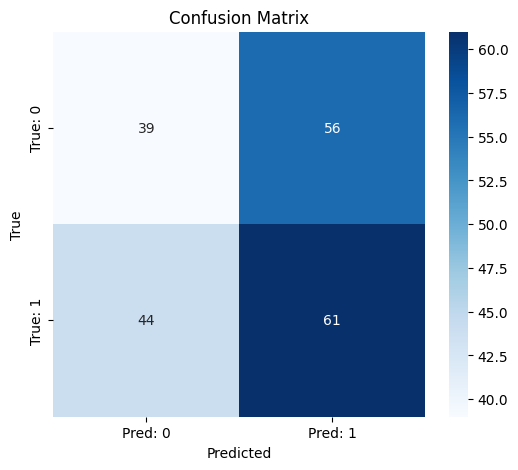

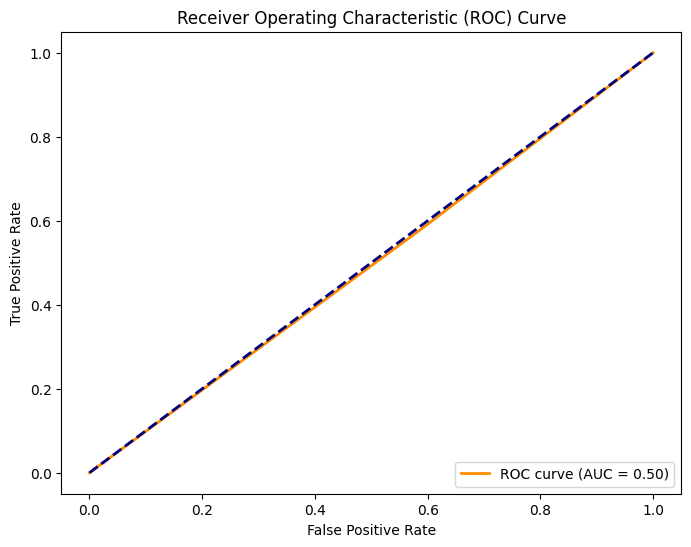

Classification Report:
               precision    recall  f1-score   support

         0.0       0.47      0.41      0.44        95
         1.0       0.52      0.58      0.55       105

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.50      0.50      0.50       200



In [ ]:
# Exercise 5
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_tensor.numpy(), test_preds.numpy()) # call confusion matrix

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test_tensor.numpy(), test_preds.numpy())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

report = classification_report(y_test_tensor.numpy(), test_preds.numpy())
print("Classification Report:\n", report)


In [ ]:
# Exercise 6
torch.save(model.state_dict(), 'logistic_regression_model.pth')

loaded_model = LogisticRegressionModel(input_dim)
loaded_model.load_state_dict(torch.load('logistic_regression_model.pth'))

loaded_model.eval()

with torch.no_grad():
    loaded_test_preds = loaded_model(X_test_tensor)
    loaded_test_preds = (loaded_test_preds >= 0.5).float()
    loaded_accuracy = (loaded_test_preds == y_test_tensor).float().mean()

    print(f"Loaded Model Test Accuracy: {loaded_accuracy:.4f}")


In [ ]:
# Exercise 7
learning_rates = [0.01, 0.05, 0.1]
best_lr = None
best_acc = 0

for lr in learning_rates:
    model = LogisticRegressionModel(input_dim)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor)
        preds = (preds >= 0.5).float()
        accuracy = (preds == y_test_tensor).float().mean()

        if accuracy > best_acc:
            best_acc = accuracy
            best_lr = lr

print(f"Best Learning Rate: {best_lr}, Test Accuracy: {best_acc:.4f}")


Best Learning Rate: 0.05, Test Accuracy: 0.5450


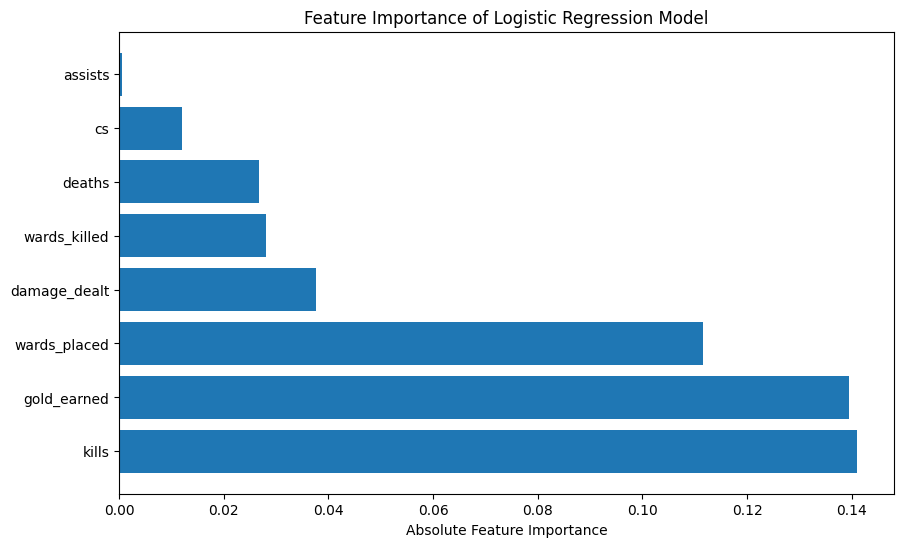

Loaded Model Test Accuracy: 0.5200


<ipython-input-12-f1208c49b701>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('logistic_regression_model.pth'))


In [ ]:
# Exercise 8
import numpy as np

weights = model.linear.weight.data.numpy().flatten()

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': weights})
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()

feature_importance_sorted = feature_importance.sort_values(by='Abs_Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Abs_Importance'])
plt.xlabel('Absolute Feature Importance')
plt.title('Feature Importance of Logistic Regression Model')
plt.show()
torch.save(model.state_dict(), 'logistic_regression_model.pth')

loaded_model = LogisticRegressionModel(input_dim)
loaded_model.load_state_dict(torch.load('logistic_regression_model.pth'))

loaded_model.eval()

with torch.no_grad():
    loaded_test_preds = loaded_model(X_test_tensor)
    loaded_test_preds = (loaded_test_preds >= 0.5).float()
    loaded_accuracy = (loaded_test_preds == y_test_tensor).float().mean()

    print(f"Loaded Model Test Accuracy: {loaded_accuracy:.4f}")
